# Feature extraction 
- x using autoencoder
- Using Latent vector of DNN classifier

## Init

In [15]:
# !pip install sentencepiece

In [16]:
# !pip install datasets evaluate transformers[sentencepiece]

In [1]:
import timm
import numpy as np
import torch
import matplotlib.pyplot as plt
import transformers
import pandas as pd
import seaborn as sns
from transformers import pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from PIL import Image

In [2]:
cd imagenet-autoencoder/

c:\Users\seung\Desktop\auto_image\Mixed-AutoEncoder\imagenet-autoencoder


In [3]:
#creating dataset
!python tools/generate_list.py --name weather_test --path ../dataset

In [4]:
data = pd.read_table('./list/weather_test_list.txt', names=["path", "class"], delimiter='\s')
label = data['class']
num_class = len(data['class'].unique())
names = ['fire','fogsmog', 'lightning', 'rain', 'sandstorm','snow']
data['name'] = [names[i] for i in data['class']]

C:\Users\seung\AppData\Local\Temp\ipykernel_10308\228420673.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_table('./list/weather_test_list.txt', names=["path", "class"], delimiter='\s')


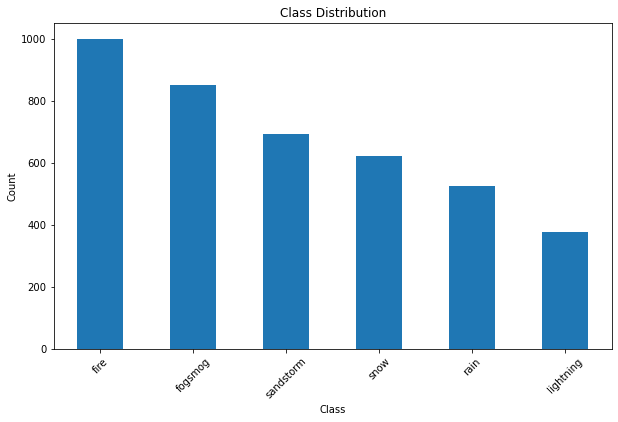

In [5]:
class_counts = data['name'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Hugging Face - feature extraction pipline

### Init

In [22]:
transformers.__version__

'4.40.1'

In [ ]:
pipeline.__annotations__

In [13]:
class pca_estimation():
    def __init__(self, input_vector, label):
        self.input_vector = input_vector
        self.label = label
    def evaluate_pca(self):
        pca=PCA()
        pca.fit(self.input_vector)
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance Ratio')
        
    def kmeans_with_pca(self,num_components, num_cluster):
        self.pca = PCA(n_components=num_components)
        latent_vector = self.pca.fit_transform(self.input_vector)
        self.kmeans = KMeans(n_clusters = num_cluster)
        y_kmeans = self.kmeans.fit_predict(latent_vector)
        conf_matrix = confusion_matrix(self.label, y_kmeans)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
        plt.xlabel('Predicted Label')
        plt.ylabel('class')

    def get_kmeans(self):
        """
        return kmeans object
        """
        return self.kmeans
    def get_pca(self):
        """
        return pca object
        """
        return self.pca

In [7]:
# Read Images
image_list = list()
for path in data['path']:
    image = Image.open(path)
    image_list.append(image)
len(image_list)

4067

### ViT224

In [8]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe_224= pipeline(task="image-feature-extraction", model_name="vit_base_patch16_224", device=DEVICE, pool=True)

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 3f49326 (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
#Start Inference
outputs = pipe_224(image_list)
#Change shapes 
np_output = np.array(outputs)
reshaped_otuput = np_output.reshape((np_output.shape[0],-1))
reshaped_otuput.shape

(4067, 768)

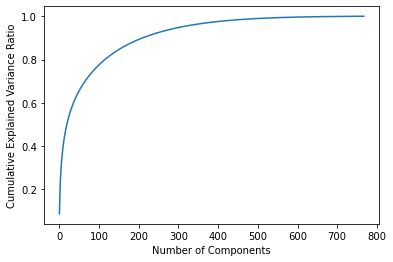

In [14]:
vit_pca = pca_estimation(reshaped_otuput, label)
vit_pca.evaluate_pca()

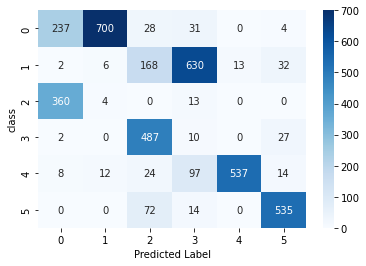

In [56]:
vit_pca.kmeans_with_pca(700,num_cluster = num_class)

In [57]:
eye_of_kmeans = vit_pca.get_kmeans()
target = eye_of_kmeans.cluster_centers_
target.shape

(6, 700)

In [58]:
index = np.arange(len(target)).reshape(-1, 1)

result = np.hstack((index, target))
np.savetxt('cluster_centers_vit224.txt', result, fmt='%d' + '\t%.8f' * target.shape[1], delimiter='\t')

### ViT 384

In [59]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch32-384')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch32-384')

C:\Users\seung\AppData\Roaming\Python\Python39\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [60]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe_384= pipeline(task="image-feature-extraction",image_processor=feature_extractor, model = model, device=DEVICE)

In [61]:
#Start Inference
o4 = pipe_384(image_list)
#Change shapes 
o4 = np.array(o4)
o4 = o4.reshape((o4.shape[0],-1))
o4.shape

(4067, 1000)

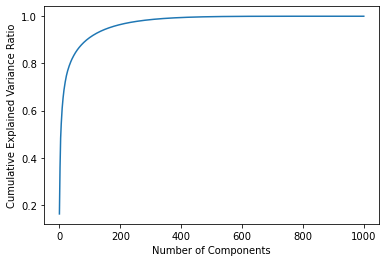

In [62]:
vit_384_pca = pca_estimation(o4, label)
vit_384_pca.evaluate_pca()

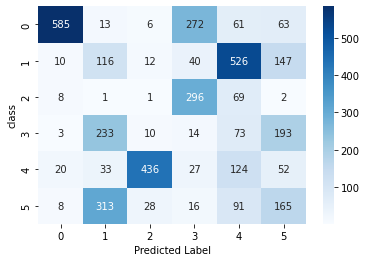

In [72]:
vit_384_pca.kmeans_with_pca(800,num_cluster=num_class)

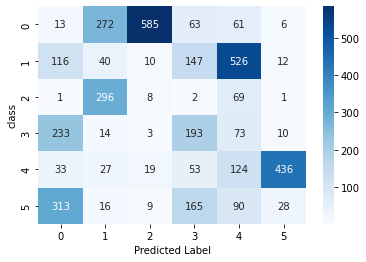

In [40]:
vit_384_pca.kmeans_with_pca(1000,num_cluster=num_class)

#### standard test

In [109]:
o4.shape

(4067, 1000)

In [115]:
tt = o4

In [120]:
max_row = np.max(o4, axis = 0)
min_row = np.min(o4, axis = 0)
col_data = []
for item in tt:
    col_data.append((item - min_row)/(max_row - min_row))
col_data = np.array(col_data).reshape((o4.shape))

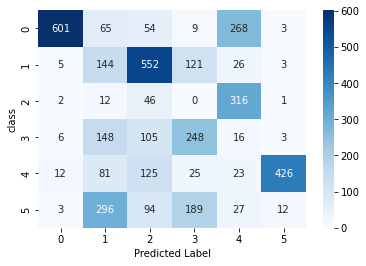

In [138]:
vit_384_pca_1= pca_estimation(col_data, label)
# vit_384_pca_1.evaluate_pca()
vit_384_pca_1.kmeans_with_pca(700,num_cluster=num_class)    

### efficient net

In [ ]:
from transformers import EfficientNetImageProcessor, EfficientNetForImageClassification


preprocessor = EfficientNetImageProcessor.from_pretrained("google/efficientnet-b0")
model = EfficientNetForImageClassification.from_pretrained("google/efficientnet-b0")

In [75]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe_eff_224 = pipeline(task="image-feature-extraction",image_processor = preprocessor, model = model, device=DEVICE)

In [76]:
#Start Inference
o2 = pipe_eff_224(image_list)
#Change shapes 
o2 = np.array(o2)
o2 = o2.reshape((o2.shape[0],-1))
o2.shape

(4067, 1000)

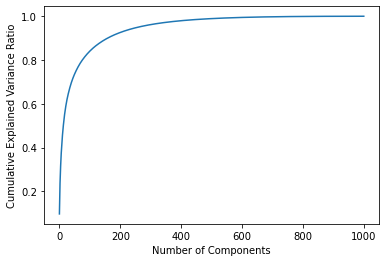

In [77]:
eff_pca = pca_estimation(o2, label)
eff_pca.evaluate_pca()

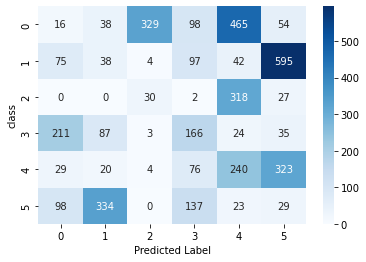

In [78]:
eff_pca.kmeans_with_pca(num_components=o2.shape[1], num_cluster = num_class)

### Resnet152

In [79]:
from transformers import AutoFeatureExtractor, ResNetForImageClassification
import torch
from datasets import load_dataset


feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-152")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-152")

C:\Users\seung\AppData\Roaming\Python\Python39\site-packages\transformers\models\convnext\feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [82]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe_res_224 = pipeline(task="image-feature-extraction",image_processor = preprocessor, model = model, device=DEVICE)

In [83]:
#Start Inference
o3 = pipe_res_224(image_list)
#Change shapes 
o3 = np.array(o3)
o3 = o3.reshape((o3.shape[0],-1))
o3.shape

(4067, 1000)

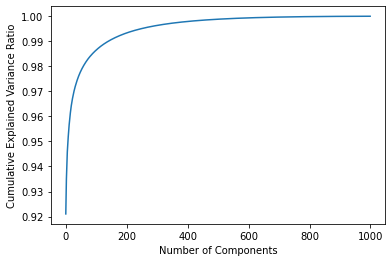

In [84]:
res_pca = pca_estimation(o3, label)
res_pca.evaluate_pca()

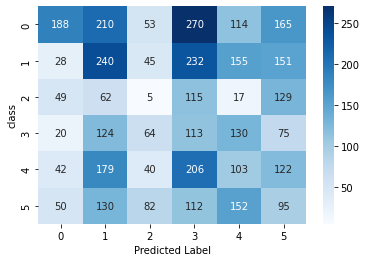

In [85]:
res_pca.kmeans_with_pca(o3.shape[1],num_cluster=num_class)

### SwinTransformer

In [42]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
model = AutoModelForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [43]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe_swin_224 = pipeline(task="image-feature-extraction",image_processor = processor, model = model, device=DEVICE)

In [44]:
#Start Inference
o5 = pipe_swin_224(image_list)
#Change shapes 
o5 = np.array(o5)
o5 = o5.reshape((o5.shape[0],-1))
o5.shape

(4067, 1000)

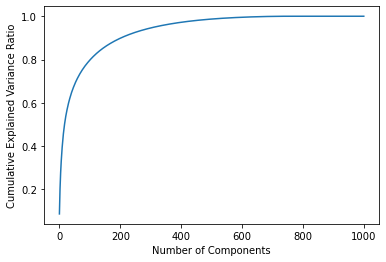

In [46]:
swin_pca = pca_estimation(o5, label)
swin_pca.evaluate_pca()

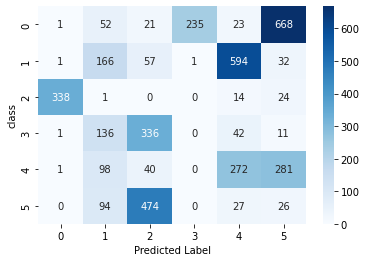

In [49]:
swin_pca.kmeans_with_pca(num_components=600, num_cluster = num_class)

### MLP-MIXER

In [ ]:
model = timm.create_model('mixer_b16_224.goog_in21k', pretrained=True)

In [ ]:
target_layer = "norm"

In [ ]:
modules

In [61]:
modules = list(model.children())

# 선택한 레이어까지의 모듈 중에서 선택한 레이어까지의 인덱스 찾기
selected_layer_index = None
for idx, module in enumerate(modules):
    if hasattr(module, target_layer):
        selected_layer_index = idx

if selected_layer_index is None:
    raise ValueError(f"Selected layer '{target_layer}' not found in the model.")

# 선택한 레이어까지의 모듈로 새로운 모델 생성
model = torch.nn.Sequential(*modules[:selected_layer_index + 1])

In [ ]:
model

In [59]:
tt = torch.rand(1,3,224,224)
o = model(tt)
o.shape

torch.Size([1, 196, 21843])

In [37]:
target_layer = "norm"
# model = torch.nn.Sequential(*list(model.children())[:model.index(target_layer) + 1])

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe_swin_224 = pipeline(task="image-feature-extraction",image_processor =   transforms,config=data_config, model = model, device=DEVICE, )